# Importing Packages

In [1]:
#import requests
#from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# Raw Data Observations and Attributes Legend

Each point, or observation, within the dataset consists of an individual chess game. The observations collected about each chess game include the following attributes:

* Event: The formal naming for this instance's time control variation
* Black: The Lichess username of the player using black pieces
* White: The Lichess username of the player using white pieces
* Result: The result of each game, denoted by '1-0' for White winning, '0-1' for Black winning, and '0.5-0.5' for a draw 
* UTCDate: The date in which the game was played
* UTCTime: The time in which the game was played
* WhiteELO: The Elo ratings for the white player
* BlackELO: The Elo ratings for the black player
* WhiteRatingDiff: How many points White gains/loses from the outcome of the game
* BlackRatingDiff: How many points Black gains/loses from the outcome of the game
* ECO: The Encyclopedia Chess Opening codes (which denotes the opening moves used by each player via a shorthand code)
* Opening: The full name of the played opening strategy
* Time Control: The Time Control for each game in seconds (time limits broken down into the format ‘Base Time + Increment’)
    * Base Time is the total base time given to each player for the entire game 
    * Increment is the additional time added to each player’s total time after each of their respective moves
* Termination: The Termination of each game (how each game was ended). The two main ones are:
    * Normal - a player was checkmated (left with no more moves)
    * Time forfeit - a player's base time reached 0 seconds before either player was able to complete the game
* AN: The exact moves each player did during the game

### Importing Data

Here we imported raw data from a csv file that we downloaded from our Kaggle data source. This is stored inside the value chess_games. 

In [2]:
#Import raw data
chess_games = pd.read_csv('chess_games.csv')

### Changing Column Types

After inspecting the excel file, we realized that the UTCDate and UTCTime columns used strange formatting which would not convert properly into a dataframe. To rectify this, we coverted these columns to datetime. We also ran a test to confirm that the dtypes for other columns are expected. 

In [3]:
#Data Cleaning - convert date and time columns to datatime objects
chess_games['UTCDate'] = pd.to_datetime(chess_games['UTCDate'])
chess_games['UTCTime'] = pd.to_datetime(chess_games['UTCTime'])

display(chess_games.head())

#Check to ensure each column type is correct
print(chess_games.dtypes)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016-06-30,2022-12-09 22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016-06-30,2022-12-09 22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016-06-30,2022-12-09 22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Correspondence,Jvayne,Wsjvayne,1-0,2016-06-30,2022-12-09 22:00:02,1706,1317,27.0,-25.0,A00,Van't Kruijs Opening,-,Normal,1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...
4,Blitz tournament,kyoday,BrettDale,0-1,2016-06-30,2022-12-09 22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...


Event                      object
White                      object
Black                      object
Result                     object
UTCDate            datetime64[ns]
UTCTime            datetime64[ns]
WhiteElo                    int64
BlackElo                    int64
WhiteRatingDiff           float64
BlackRatingDiff           float64
ECO                        object
Opening                    object
TimeControl                object
Termination                object
AN                         object
dtype: object


### Filtering Termination Types
The first column that we wanted to clean was the termination and results columns. In these columns, there were a couple of values which did not make sense in the context of the data. We also wanted to filter out terminations due to abandoned games, caused when one player suddenly quits, or rules infractions, caused when a player is found to be cheating.

This cleaned data is stored in the value completed_chess_games.

In [4]:
#filter out Termination = Abandoned, Rules infraction, filtering out TimeControl = '-'
#checking that there are no games where result is * (meaning incomplete)
completed_chess_games = %sql SELECT * FROM chess_games \
WHERE Termination NOT IN ('Abandoned', 'Rules infraction') \
    AND TimeControl != '-' \
    AND Result != '*'

### Removing Initial NaNs
Here, we filtered out all the NaNs from the completed_chess_games dataset. 

In [5]:
#filter out all NaN values
completed_chess_games = completed_chess_games.dropna()
completed_chess_games.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016-06-30,2022-12-09 22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016-06-30,2022-12-09 22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016-06-30,2022-12-09 22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Blitz tournament,kyoday,BrettDale,0-1,2016-06-30,2022-12-09 22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
4,Blitz tournament,lucaseixasouza,diguim,0-1,2016-06-30,2022-12-09 22:00:02,1773,1809,-10.0,10.0,C27,Vienna Game,180+0,Normal,1. e4 e5 2. Nc3 d6 3. Nf3 h6 4. Bc4 c6 5. b3 Q...


### Dropping Unnecessary Columns and Adding an ELO Rating Differential Column

In [6]:
#Creating a new table filtering out unneccsary columns
#Creating a column WhiteRatingDiff for the rating differential between White and Black from white's perspective
completed_chess_games = %sql SELECT Event, Result, WhiteElo, BlackElo, (WhiteElo - BlackElo) AS WhiteRatingDiff, ECO, Opening, TimeControl, Termination \
FROM completed_chess_games

### Removing Additional NaNs
Again, we had some NaNs in our dataframe under the WhiteRatingDiff column which arose due to the previous calculations.

In [7]:
#filter out all NaN values
completed_chess_games = completed_chess_games.dropna()
completed_chess_games

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination
0,Classical,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit
1,Blitz,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal
2,Blitz tournament,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit
3,Blitz tournament,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit
4,Blitz tournament,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal
...,...,...,...,...,...,...,...,...,...
6215894,Blitz,1-0,1248,1303,-55,B54,Sicilian Defense,180+3,Normal
6215895,Classical,1-0,1328,1292,36,C40,King's Knight Opening,1800+0,Normal
6215896,Bullet,0-1,1660,1658,2,B21,Sicilian Defense: Smith-Morra Gambit,120+0,Normal
6215897,Bullet,0-1,1726,1776,-50,A09,Reti Opening: Reti Accepted,60+0,Normal


### Taking Top 10% of Rows
Because our cleaned dataset of completed chess games was so large (~6.2 million rows), we decided to only take the top 10% of rows.

We decided to use the top 10% of rows from the completed chess games as opposed to grouping by Opening, ELO Rating Differential, Time Control, or ELO Rating and taking the top 10% of rows from the group is that grouping the data by one variable can skew the distributions of the other variables in the data and in turn, skew the analysis of the data. It would not be a true random sample like taking the top 10% of rows.

In [8]:
#Sliced distribution - taking the top 10% of rows 
chess_games_cut = completed_chess_games[completed_chess_games['Event'].index <= len(completed_chess_games)*.10]

### Splitting Time Control Columns
One of the final things to clean was the time control column. In chess, a time control is split into a base and an increment. The base denotes how much time you have to play the game and the increment denotes how much time is added to your remaining time per move you play. The standard notation for this is time control = base+increment.

Here, we wanted to split the base and increment into their own columns to make the data easier to understand. After doing this, we joined the data from the time control rows with the data from the top 10% of rows. We then changed the units to make more sense, checked that the dtype for the new columns was correct, and saved this dataset into a new dataframe.

In [9]:
#spliting base and incremental into two different columns
#split the time control into two columns - Base and Incremental
time_control_df = chess_games_cut.TimeControl.apply(lambda x: pd.Series(str(x).split("+")))

time_control_df = time_control_df.rename(columns={0:"Base", 1:"Increment"})
display(time_control_df)

#Join chess games 10% cut df with time control split df together
chess_games_tc_split = pd.concat([chess_games_cut, time_control_df], axis=1)
print(chess_games_tc_split.dtypes)

#removing first column which has row numbers only
chess_games_tc_split = chess_games_tc_split.iloc[:,1:]

#converting 'Base' to minutes in floats and 'Increment' in ints
chess_games_tc_split['Base'] = chess_games_tc_split['Base'].astype(int) / 60
#chess_games_tc_split['Base'] = chess_games_tc_split['Base'] / 60
chess_games_tc_split['Increment'] = chess_games_tc_split['Increment'].astype(int)

#renaming Base and Increment columns with units
chess_games_tc_split = chess_games_tc_split.rename(columns = {'Base': 'Base (min)', 'Increment': 'Increment (sec)'})

#checking for data types of each column
print(chess_games_tc_split.dtypes)
display(chess_games_tc_split)

,Base,Increment
0,300,5
1,300,0
2,180,0
3,180,0
4,180,0
...,...,...
621585,60,0
621586,300,0
621587,300,4
621588,180,0


Event              object
Result             object
WhiteElo            int64
BlackElo            int64
WhiteRatingDiff     int64
ECO                object
Opening            object
TimeControl        object
Termination        object
Base               object
Increment          object
dtype: object
Result              object
WhiteElo             int64
BlackElo             int64
WhiteRatingDiff      int64
ECO                 object
Opening             object
TimeControl         object
Termination         object
Base (min)         float64
Increment (sec)      int64
dtype: object


,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec)
0,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit,5.0,5
1,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal,5.0,0
2,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,3.0,0
3,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,3.0,0
4,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal,3.0,0
...,...,...,...,...,...,...,...,...,...,...
621585,0-1,1798,1753,45,B06,Modern Defense,60+0,Time forfeit,1.0,0
621586,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,300+0,Normal,5.0,0
621587,1-0,1762,1683,79,C00,St. George Defense,300+4,Normal,5.0,4
621588,1-0,2023,1742,281,A45,Indian Game,180+0,Normal,3.0,0


### Converting strings in the opening column to lowercase
As we would further categorize the openings to four types, we needed the strings to be in lowercase to capture all openings regardless of case.

In [12]:
chess_games_tc_split['Opening'] = chess_games_tc_split['Opening'].str.lower()

# Data Sample Distribution Testing 
**Data Testing: Opening Distributions**

Because we sliced to only include the top 10% of rows, we wanted to ensure that the data was relatively similar, specifically in the distributions of openings. We did this by comparing the number of occurances of each opening before and after our slice, as well as the percentage of the total that these openings were. We then compared the difference in percentage of the density of these openings before and after our split, creating a new column Percent_Diff in a new joined table. 

As shown in the resulting table, some openings which were only played in games that were sliced did not show up after the slice happened. These resulted in NaN values for Cut_Count, Cut_Percent_Tot, and Percent_Diff. 

Given that the percent difference was so small between the sliced and original dataset, we can assume that our slice is accurate at representing our original dataset. 

In [13]:
#TESTING DISTRIBUTIONS - OPENING
#Opening distribution - pre slice
#Group by opening, and count each occurance of the opening
opening_dist = completed_chess_games.groupby(by = 'Opening')
opening_dist = opening_dist.count().sort_values(by = 'Event', ascending=False)


#Calculate the percent of total occurances for each opening 
opening_dist_1 = opening_dist.loc[:, ['Event']]
opening_dist_1 = opening_dist_1.rename(columns={"Event":"Count"}) #renaming column 'Event' to 'Count'
opening_dist_1['Percent_Tot'] = opening_dist_1['Count']/len(completed_chess_games)
#filtering for top 0.01% of rows to get rid of openings that have minimal occurances
opening_dist_1 = opening_dist_1[opening_dist_1['Percent_Tot'] > 0.0001]

#2940 rows - no filter for > 0.01% of Total
#958 rows - filter for > 0.01% of Total


#Opening distribution - post slice
#Group by opening, and count each occurance of the opening
opening_dist_cut = chess_games_cut.groupby(by = 'Opening')
opening_dist_cut = opening_dist_cut.count().sort_values(by = 'Event', ascending=False)
#opening_dist_cut

#Calculate the percent of total occurances for each opening 
opening_dist_cut_1 = opening_dist_cut.loc[:, ['Event']]
opening_dist_cut_1 = opening_dist_cut_1.rename(columns={"Event":"CUT_Count"})
opening_dist_cut_1['CUT_Percent_Tot'] = opening_dist_cut_1['CUT_Count']/len(chess_games_cut) #renaming column 'Event' to 'Count'
opening_dist_cut_1 = opening_dist_cut_1[opening_dist_cut_1['CUT_Percent_Tot'] > 0.0001]
#filtering for top 0.01% of rows to get rid of openings that have minimal occurances
#opening_dist_cut_1

#2623 rows - no filter for > 0.01% of Total
#956 rows - filter for > 0.01% of Total


#Joining pre-cut and post-cut tables
open_joined = opening_dist_1.join(opening_dist_cut_1, on = "Opening")
open_joined['Percent_Diff'] = open_joined['Percent_Tot'] - open_joined['CUT_Percent_Tot']
open_joined
#958 rows with NaN included
#924 rows NaN filtered out

,Count,Percent_Tot,CUT_Count,CUT_Percent_Tot,Percent_Diff
Opening,,,,,
Van't Kruijs Opening,131980,0.021233,13161.0,0.021173,0.000060
Scandinavian Defense: Mieses-Kotroc Variation,111905,0.018003,11614.0,0.018684,-0.000681
Modern Defense,107921,0.017362,10334.0,0.016625,0.000737
Horwitz Defense,95189,0.015314,9408.0,0.015135,0.000178
Sicilian Defense,85206,0.013708,8881.0,0.014288,-0.000580
...,...,...,...,...,...
"French Defense: Winawer Variation, Winckelmann-Riemer Gambit",628,0.000101,NaN,NaN,NaN
Caro-Kann Defense: Gurgenidze System,627,0.000101,NaN,NaN,NaN
Zukertort Opening,625,0.000101,69.0,0.000111,-0.000010


### Data Testing: ELO Rating Differential Distributions

To reaffirm that our split for our random sample was successful at representing the original dataset, we decided to create histograms of the rating differentials in the dataset before and after the split.

These distributions look the same, so we can reaffirm that the cut was successful based on rating differential.

array([[<AxesSubplot: title={'center': 'WhiteRatingDiff'}>]], dtype=object)

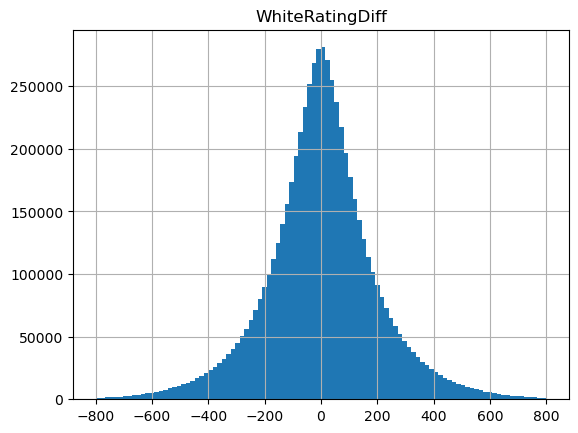

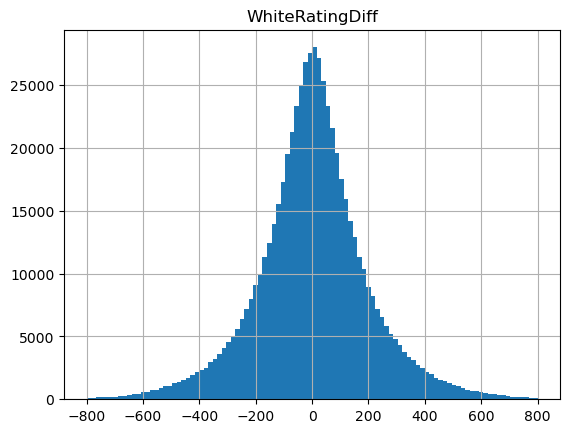

In [14]:
#TESTING DISTRIBUTIONS - RATING DIFFERENTIAL 
#TOP = Distribution of Original DF
completed_chess_games.hist(column = 'WhiteRatingDiff', bins = 100, range = (-800, 800))

#Bottom = Distribution of Cut DF
chess_games_cut.hist(column = 'WhiteRatingDiff', bins = 100, range = (-800, 800))

#Distributions look the same so good cut based on Rating Differential

### Data Testing: ELO Rating Distribution

Another way to validate if our data is properly distributed is to inspect rating distributions. Specifically, this would tell us if both datasets contain players of the same rating range. 

The histograms for both black and white's ELO rating looks the same between the datasets before and after slicing. Thus, we can assume that the cut was successful based on rating. 

array([[<AxesSubplot: title={'center': 'WhiteElo'}>,
        <AxesSubplot: title={'center': 'BlackElo'}>]], dtype=object)

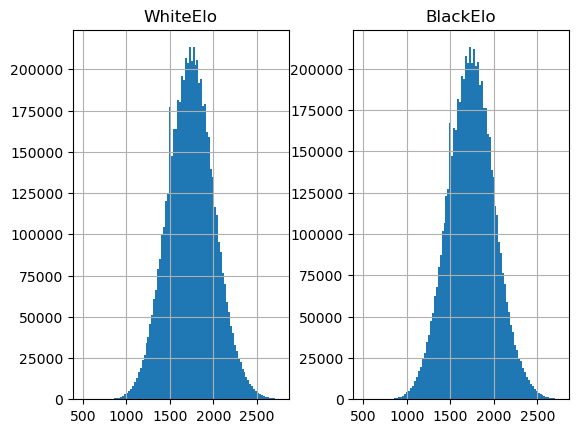

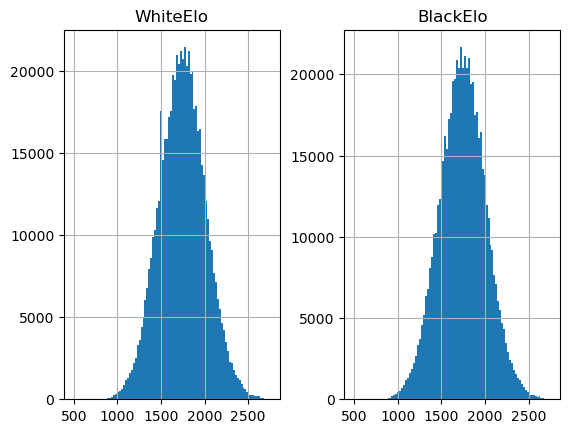

In [15]:
#TESTING DISTRIBUTIONS - RATING  
#TOP = Distribution of Original DF
completed_chess_games.hist(column = ['WhiteElo', 'BlackElo'], bins = 100, range = (500,2750))

#BOTTOM = Distribution of Cut DF
chess_games_cut.hist(column = ['WhiteElo', 'BlackElo'], bins = 100, range = (500,2750))


#Distributions look the same so good cut based on Rating

### Data Testing: Time Control Distributions

As we did previously, we wanted to ensure that the data was relatively similar, specifically in the distributions of time controls. We did this by comparing the number of occurances of each time control before and after our slice, as well as the percentage of the total that these controls were. We then compared the difference in percentage of the density of these controls before and after our split, creating a new column Percent_Diff in a new joined table. 

As shown in the resulting table, some controls which were only played in games that were sliced did not show up after the slice happened. These resulted in NaN values for Cut_Count, Cut_Percent_Tot, and Percent_Diff. 

Given that the percent difference was so small between the sliced and original dataset, we can assume that our slice is accurate at representing our original dataset. 

In [16]:
#TESTING DISTRIBUTIONS - TIME CONTROL
#Time Control distribution - pre slice
#Group by Time Control, and count each occurance of the Control
timecontrol_dist = completed_chess_games.groupby(by = 'TimeControl')
timecontrol_dist = timecontrol_dist.count().sort_values(by = 'Event', ascending=False)


#Calculate the percent of total occurances for each opening 
timecontrol_dist_1 = timecontrol_dist.loc[:, ['Event']]
timecontrol_dist_1 = timecontrol_dist_1.rename(columns={"Event":"Count"})
timecontrol_dist_1['Percent_Tot'] = timecontrol_dist_1['Count']/len(completed_chess_games)
timecontrol_dist_1 = timecontrol_dist_1[timecontrol_dist_1['Percent_Tot'] > 0.0001]

#840 rows - no filter for 0.01% of Total
#189 rows - filter for 0.01% of Total


#Opening distribution - post slice
#Group by opening, and count each occurance of the opening
timecontrol_dist_cut = chess_games_cut.groupby(by = 'TimeControl')
timecontrol_dist_cut = timecontrol_dist_cut.count().sort_values(by = 'Event', ascending=False)
timecontrol_dist_cut

#Calculate the percent of total occurances for each opening 
timecontrol_dist_cut_1 = timecontrol_dist_cut.loc[:, ['Event']]
timecontrol_dist_cut_1 = timecontrol_dist_cut_1.rename(columns={"Event":"CUT_Count"})
timecontrol_dist_cut_1['CUT_Percent_Tot'] = timecontrol_dist_cut_1['CUT_Count']/len(chess_games_cut)
timecontrol_dist_cut_1 = timecontrol_dist_cut_1[timecontrol_dist_cut_1['CUT_Percent_Tot'] > 0.0001]
timecontrol_dist_cut_1

#534 rows - no filter for > 0.01% of Total
#182 rows - filter for > 0.01% of Total


#Joining pre-cut and post-cut tables
tc_joined = timecontrol_dist_1.join(timecontrol_dist_cut_1, on = "TimeControl")
tc_joined['Percent_Diff'] = tc_joined['Percent_Tot'] - tc_joined['CUT_Percent_Tot']
tc_joined

,Count,Percent_Tot,CUT_Count,CUT_Percent_Tot,Percent_Diff
TimeControl,,,,,
300+0,1071549,0.172388,106906.0,0.171988,0.000400
180+0,945369,0.152089,94972.0,0.152789,-0.000700
60+0,909552,0.146327,92614.0,0.148995,-0.002669
600+0,576641,0.092769,58983.0,0.094891,-0.002122
30+0,306403,0.049293,23946.0,0.038524,0.010770
...,...,...,...,...,...
660+7,651,0.000105,82.0,0.000132,-0.000027
300+9,651,0.000105,NaN,NaN,NaN
540+10,641,0.000103,NaN,NaN,NaN


## Computing Win Rates of Each Opening

As part of our research question is about predicting win probability with opening played, we computed the win rate of each opening. 

First, we changed the name of the dataframe to chess_games for simplicity. 

Then, we tallied the number of games played for each opening in a data frame and then tallied the number of games won for each opening in another data frame.  We then joined the 2 data frames by opening.

Since there were openings with no games won, joining the two data frames resulted in NaNs in the Games_Won column. We thus dropped all NaNs.

Because we did not want openings that were played infrequently to seemingly have high win rates, we dropped all openings that had fewer than 50 games played.

Finally, we computed the win rate by dividing Games_Won by Games_Played and dropped the Games_Won and Games_Played columns.

In [17]:
#changing name of data frame for simplicity
chess_games = chess_games_tc_split

#all openings with corresponding number of games played
%sql opening_games_played << SELECT Opening, COUNT(ECO) As Games_Played \
FROM chess_games GROUP BY Opening ORDER BY Games_Played DESC

print(opening_games_played)

#all openings with corresponding number of games won
%sql opening_games_won << SELECT Opening, COUNT(ECO) AS Games_Won \
FROM chess_games WHERE Result = '1-0' GROUP BY Opening ORDER BY Games_Won DESC

print(opening_games_won)

#joining games played and games won by opening
%sql opening_games << SELECT opening_games_played.Opening, Games_Played, Games_Won \
FROM opening_games_played LEFT JOIN opening_games_won \
ON opening_games_played.Opening = opening_games_won.Opening ORDER BY Games_Played DESC

#drop NaNs --> NaNs in Games_Won column indicate that opening has 0 games won
opening_games.dropna()
print(opening_games)

#filter for openings that have at least 50 games played
opening_games = opening_games[opening_games['Games_Played'] >= 50]

#compute win rate column and sort by win rate
opening_games['Win_Rate'] = opening_games['Games_Won'] / opening_games['Games_Played']
opening_win_rate = opening_games.sort_values(by = ['Win_Rate'], ascending = False)

#drop columns Games_Played and Games_Won; rename Opening to Opening_Type for later merging
opening_win_rate = opening_win_rate.drop(columns = ['Games_Played', 'Games_Won'])
opening_win_rate = opening_win_rate.rename(columns={'Opening': 'Opening_Type'})

display(opening_win_rate)

Returning data to local variable opening_games_played
                                                Opening  Games_Played
0                                  van't kruijs opening         13161
1         scandinavian defense: mieses-kotroc variation         11614
2                                        modern defense         10334
3                                       horwitz defense          9408
4                                      sicilian defense          8881
...                                                 ...           ...
2618  king's indian defense: fianchetto variation, p...             1
2619  french defense: alekhine-chatard attack, teich...             1
2620      ruy lopez: classical defense: boden variation             1
2621                       english opening: wade gambit             1
2622  pirc defense: 150 attack, sveshnikov-jansa attack             1

[2623 rows x 2 columns]
Returning data to local variable opening_games_won
                              

,Opening_Type,Win_Rate
614,"italian game: two knights defense, knight attack",0.790850
934,indian game: normal variation,0.772727
737,"italian game: two knights defense, max lange a...",0.735849
947,scandinavian defense: anderssen counterattack,0.734375
878,italian game: scotch gambit declined,0.733333
...,...,...
1047,nimzowitsch defense: scandinavian variation,0.326923
685,"queen's pawn opening: veresov, richter attack",0.322314
70,king's pawn game,0.321090
804,"sicilian defense: sozin attack, leonhardt vari...",0.311111


### Appending win probability to the list of all chess games

Using the data frame with each opening and its corresponding win rate, we appended the win probability to each chess game played according to the opening played. Since we had fewer openings with win rates after filtering to at least 50 games played,  we used an inner join to avoid NaNs for chess games that had openings that were not in the list of openings with win rates data frame. 

In [18]:
#adding win rate to individual games data frame
%sql chess_games_rate << SELECT * FROM chess_games INNER JOIN opening_win_rate \
ON chess_games.Opening = opening_win_rate.Opening_Type

chess_games_rate = chess_games_rate.drop(columns = ['Opening_Type'])
display(chess_games_rate)

Returning data to local variable chess_games_rate


,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec),Win_Rate
0,0-1,1641,1627,14,C20,king's pawn opening: 2.b3,300+0,Normal,5.0,0,0.412060
1,1-0,1647,1688,-41,B01,scandinavian defense: mieses-kotroc variation,180+0,Time forfeit,3.0,0,0.558550
2,0-1,1945,1900,45,B90,"sicilian defense: najdorf, lipnitsky attack",180+0,Time forfeit,3.0,0,0.444695
3,0-1,1773,1809,-36,C27,vienna game,180+0,Normal,3.0,0,0.579278
4,0-1,1895,1886,9,B10,caro-kann defense: two knights attack,180+0,Time forfeit,3.0,0,0.521220
...,...,...,...,...,...,...,...,...,...,...,...
601600,0-1,1798,1753,45,B06,modern defense,60+0,Time forfeit,1.0,0,0.480550
601601,0-1,1711,1578,133,B08,pirc defense: classical variation,300+0,Normal,5.0,0,0.457798
601602,1-0,1762,1683,79,C00,st. george defense,300+4,Normal,5.0,4,0.539982
601603,1-0,2023,1742,281,A45,indian game,180+0,Normal,3.0,0,0.450352


## Saving csv files of the cleaned, analysis-ready data frame and other data frames for data analysis

In [19]:
chess_games_rate.to_csv('chess_games_cleaned.csv')
opening_games.to_csv('opening_games.csv')